In [2]:
from scipy.io import wavfile
from scipy.signal import resample
def load_wav(filename,samplerate=44100):
    # load file
    rate, data = wavfile.read(filename)
    # convert stereo to mono
    if len(data.shape) > 1:
        data = data[:,0]/2 + data[:,1]/2
    # re-interpolate samplerate    
    ratio = float(samplerate) / float(rate)
    print("Ratio: {ratio}".format(ratio=ratio))
    data = resample(data, len(data) * int(ratio))

    return samplerate, data

[(8000, array([  9, 121, 131, ..., 160, 168, 182], dtype=uint8)), (8000, array([  9, 121, 131, ..., 160, 159, 153], dtype=uint8)), (8000, array([124, 119, 124, ..., 158, 177, 180], dtype=uint8))]


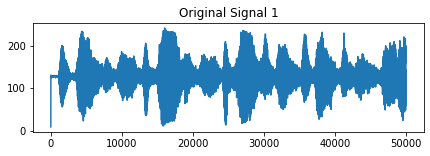

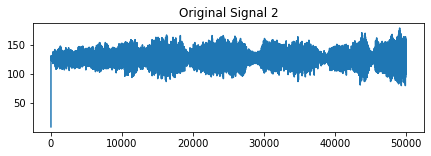

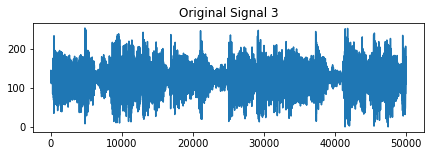

In [3]:
import matplotlib.pyplot as plt
import numpy as np
sources = ['./Audio_files/source5.wav', './Audio_files/source7.wav', './Audio_files/source9.wav']
fs_sources = []
for source in sources:
    fs_sources.append(wavfile.read(source))
print(fs_sources)
sources = [ x[1] for x in fs_sources]
sources = np.array(sources)
sources_reshape = []
fs = fs_sources[0]
length = max([ len(x[1]) for x in fs_sources])
for source in sources:
    source.resize((length), refcheck=False)
    sources_reshape.append(source)
sources = sources_reshape
#print(sources)
for i,source in enumerate(sources):
    plt.figure(figsize=(7,2))
    plt.plot(source)
    plt.title('Original Signal %d' % (i+1))
    plt.show()
num_noises = 1
for i in range(num_noises):    
    noise = 1e-1 * np.random.normal(0, 1, size=sources[0].size)
    sources.append(noise)
sources = np.array(sources)

In [4]:
import numpy as np

fs = fs
S = sources
keys = np.array(np.argsort(-np.multiply(S, S).sum(axis=1)))
print(keys)
S = S[keys, :]
n = S.shape[0]

#To reproduce exactly the same result as in the paper
A = np.load('A_new_4.npy')

#To generate new random mixxing matrix
#A = np.random.rand(n,n)
#A,_ = np.linalg.qr(A)

[2 0 1 3]


In [4]:
print(A)

[[-0.34212417  0.36551895  0.73647851  0.45491357]
 [-0.41805611 -0.26449439  0.41028742 -0.76611751]
 [-0.56616617  0.64856356 -0.47897554 -0.17147479]
 [-0.62260422 -0.61302848 -0.24463456  0.42037364]]


float64


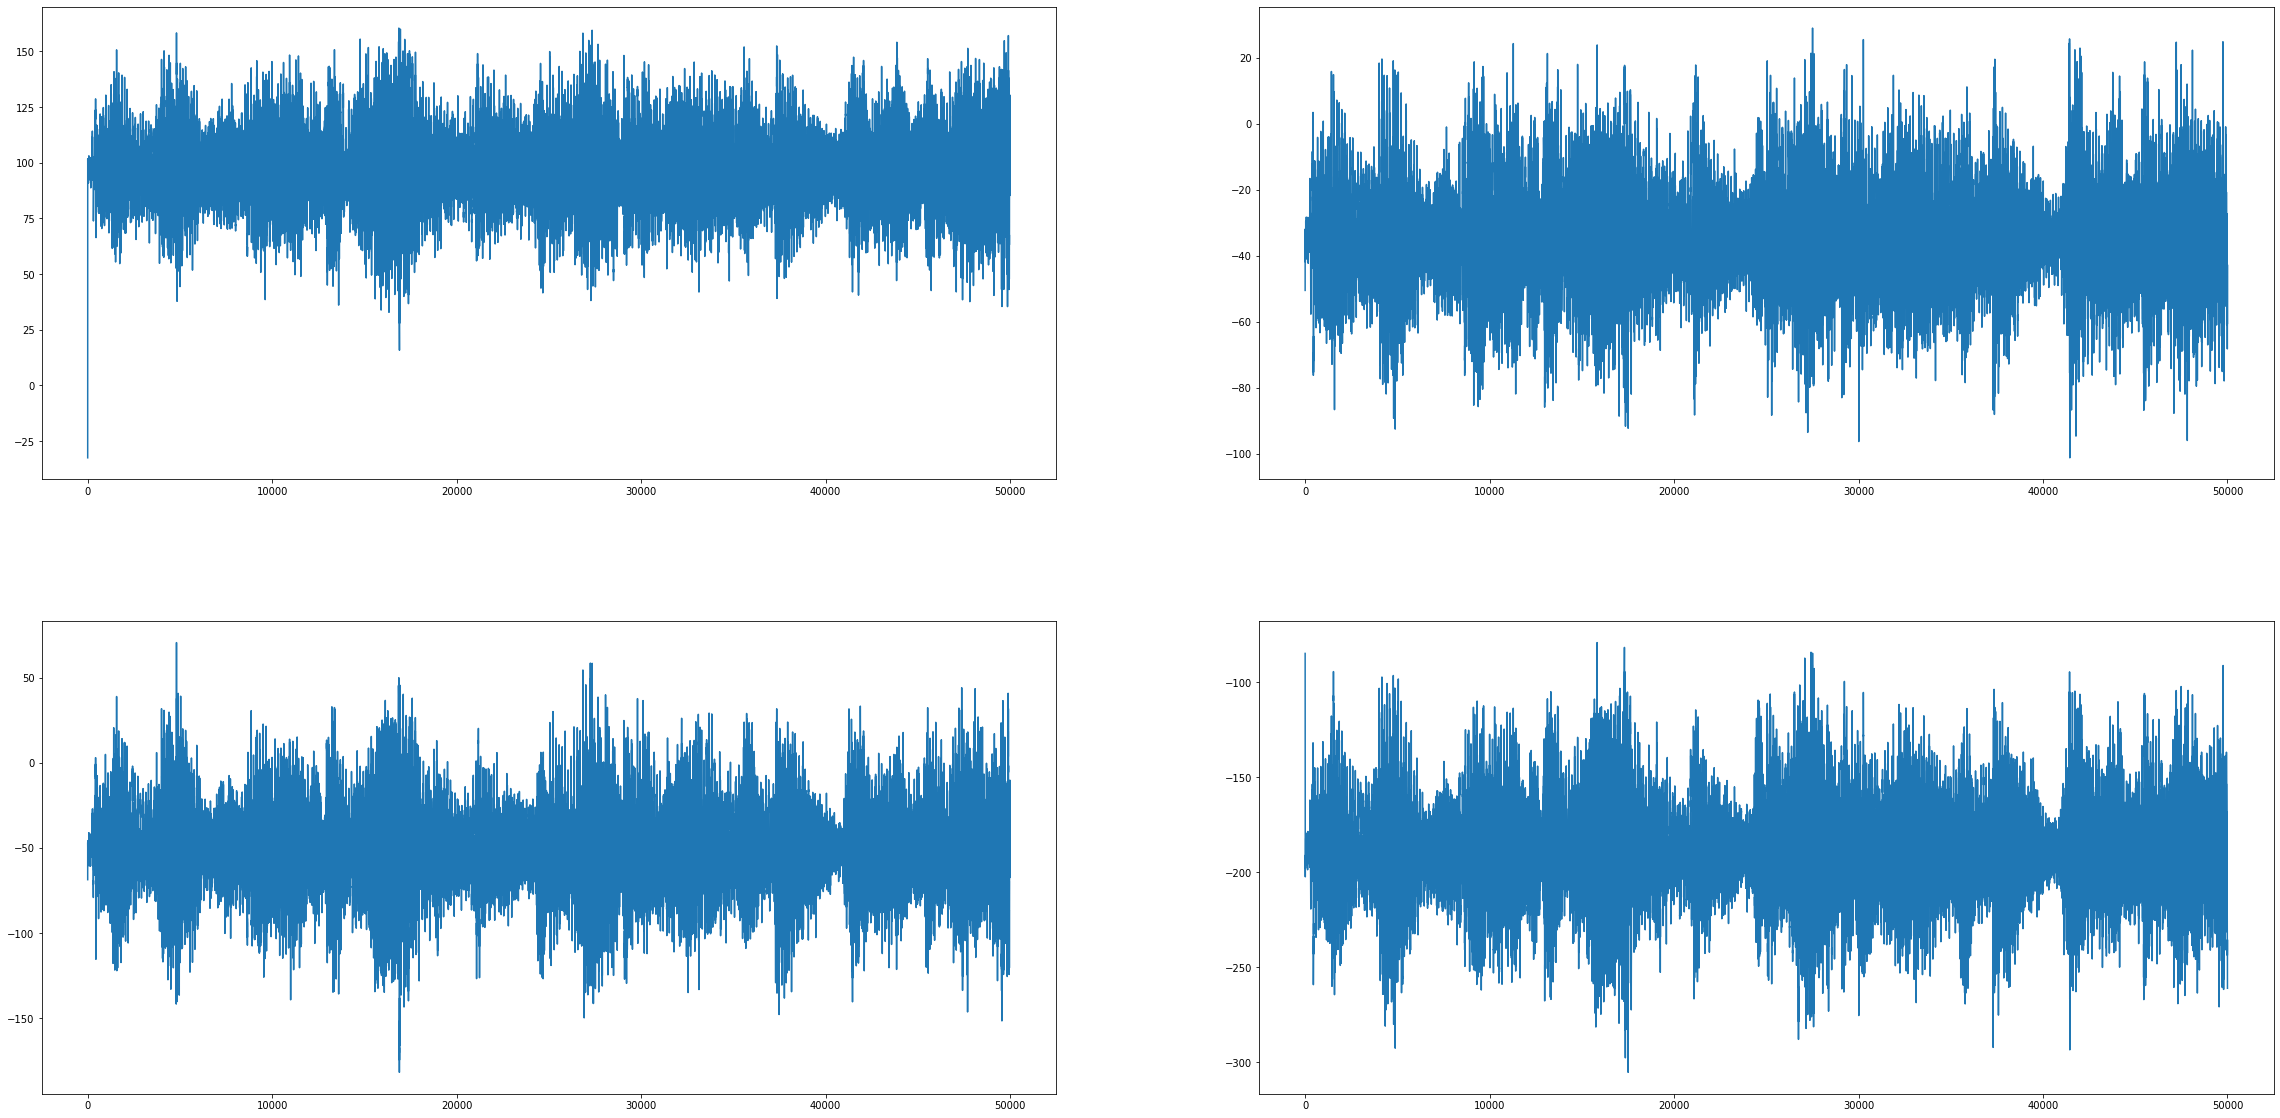

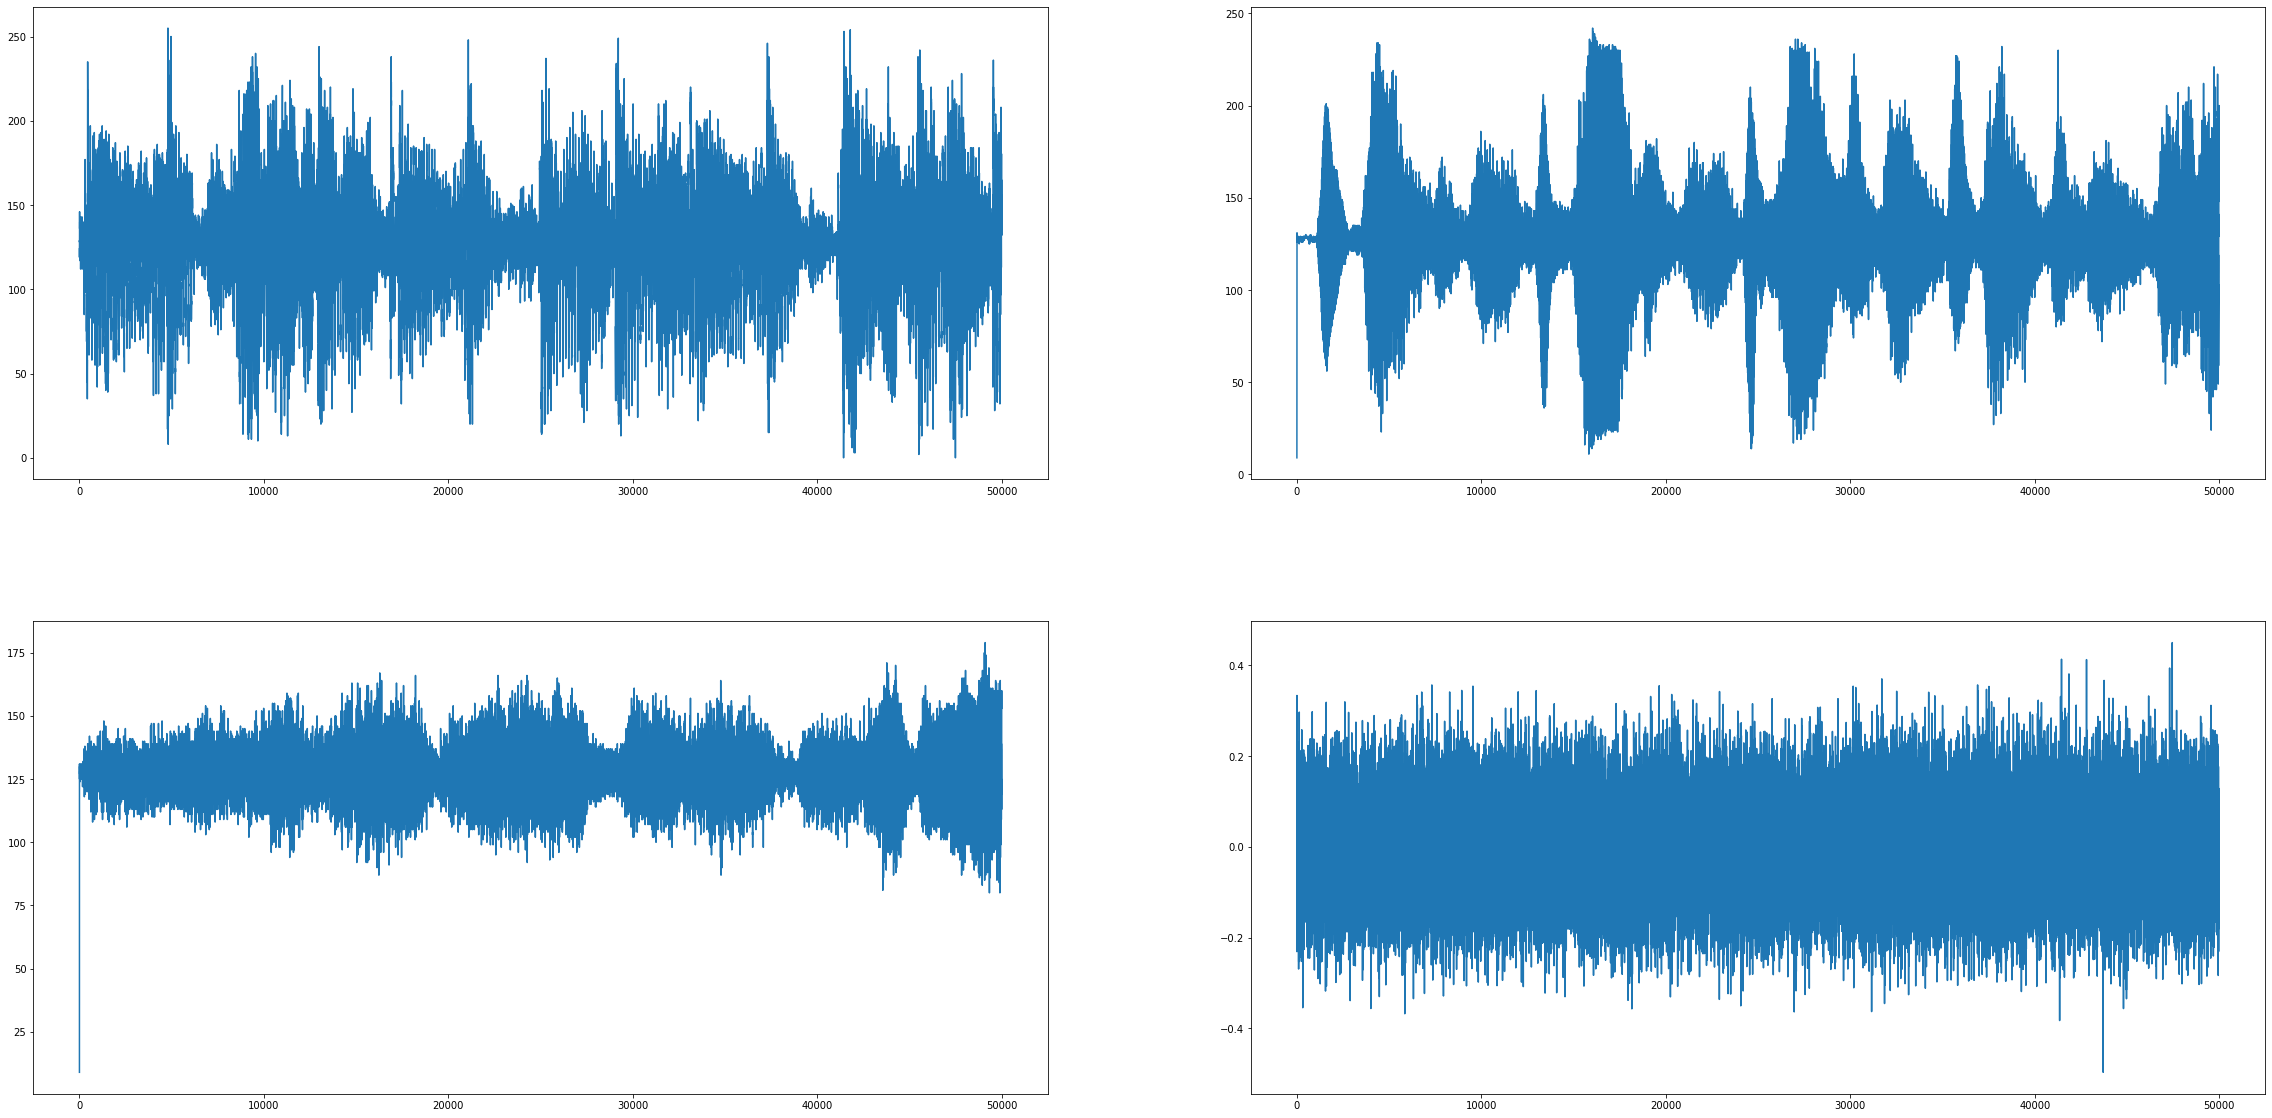

In [5]:
X = A @ S

# Exploring Mixed Signals
print(X.dtype)
h,w = 2, 2
fig = plt.figure(figsize=(40,20),facecolor=(1, 1, 1))
axs = fig.subplots(h,w)
plt.subplots_adjust(hspace=0.3)
for i in range(X.shape[0]):
    ax = axs[i // w, i % w]
    ax.plot(X[i])
plt.savefig("Mixed Signal.png", bbox_inches='tight')

fig = plt.figure(figsize=(40,20),facecolor=(1, 1, 1))
axs = fig.subplots(h,w)
plt.subplots_adjust(hspace=0.3)
for i in range(S.shape[0]):
    ax = axs[i // w, i % w]
    ax.plot(S[i])

plt.savefig("Original Signal.png", bbox_inches='tight')

In [12]:
import sys 
sys.path.append('..')
from time import time
from rjd import *
from bss_util import jadeR
from other_jd_algorithms import *
algos = ['FFDIAG', 'JADE', 'RJD', 'DRJD']
time_dict = {algo: 0 for algo in algos}
tries = 100
n = A.shape[0]
max_lag = 10
Bs_jade, Bs_rand, Bs_rand_deflat, Bs_ffdiag = np.zeros((n,n,tries)), \
    np.zeros((n,n,tries)),np.zeros((n,n,tries)),np.zeros((n,n,tries))
Bs_dict = {'JADE':Bs_jade, 'RJD' : Bs_rand, 'DRJD':Bs_rand_deflat, 
    'FFDIAG':Bs_ffdiag
}
m = A.shape[1]
for i in range(tries):
    
    B_rand_deflat,rt = jadeR(X,jd_function=lambda x :randomized_jd_deflat(x,trails=3))
    time_dict['DRJD'] += rt
    Bs_rand_deflat[:,:,i] = B_rand_deflat

    B_jade,rt = jadeR(X,jd_function=lambda x : rjd(x)[0])
    time_dict['JADE'] += rt
    Bs_jade[:,:,i] = B_jade

    B_rand, rt = jadeR(X,jd_function=lambda x :randomized_jd(x,3))
    time_dict['RJD'] += rt
    Bs_rand[:,:,i] = B_rand

    B_ffdiag, rt = jadeR(X,jd_function=ortho_ffdiag,transpose=False)
    time_dict['FFDIAG'] += rt
    Bs_ffdiag[:,:,i] = B_ffdiag
for algo in time_dict.keys():
    time_dict[algo] = 1000 * time_dict[algo] /  tries
print(time_dict)

{'FFDIAG': 4.6459221839904785, 'JADE': 2.7820229530334473, 'RJD': 0.29952049255371094, 'DRJD': 1.2288331985473633}


In [13]:
def MA_index(M):
    n = M.shape[0]
    s = 0
    for p in range(n):
        p_col = np.abs(M[:,p])
        p_row = np.abs(M[p,:])
        s+= np.sum(p_col)/ np.max(p_col)
        s+= np.sum(p_row)/ np.max(p_row)
        s-=2
    return s/(2*n*(n-1))

MD_dict = {}
for algo in algos:
    ma_score = 0
    Bs = Bs_dict[algo]
    tries = Bs.shape[2]
    for i in range(tries):
        ma_score += MA_index(Bs[:,:,i] @ A)
    MD_dict[algo] = ma_score / tries
    
def print_time_error(name, time,error, bold = False):
    if not bold:
        output_str = name + " & " + "$\\num{%f}$" + " & " + "$\\num{%f}$" + "\\\\\n" + "\hline"
    else:
        output_str = "{\\bf " + name + "}" + " & " + "$\\num{%f}$" + " & " + "$\\num{%f}$" + "\\\\\n" + "\hline"
    print(output_str % (time, error))

def make_table(time_dict, md_dict):
    title_str = "\\begin{table}[!hbt!]\n" + "\\begin{center}\n" + \
                    "\\caption{Average Running Time and MA Index Comparison for Audio Data" \
                +"}\n" +"\\begin{tabular}{||c | c | c | |}\n" + "\\hline\n"
    title_str += "Algorithm Name & Avg Runtime(ms) & Avg MA Index\\\\\n" + "\\hline"
    print(title_str)
    for algo in time_dict.keys():
        print_time_error(algo,time_dict[algo],md_dict[algo])
    closing_str = "\\end{tabular}\n" + "\\end{center}\n" + \
        "\\end{table}"
    print(closing_str)

make_table(time_dict, MD_dict)

\begin{table}[!hbt!]
\begin{center}
\caption{Average Running Time and MA Index Comparison for Audio Data}
\begin{tabular}{||c | c | c | |}
\hline
Algorithm Name & Avg Runtime(ms) & Avg MA Index\\
\hline
FFDIAG & $\num{4.645922}$ & $\num{0.074119}$\\
\hline
JADE & $\num{2.782023}$ & $\num{0.074109}$\\
\hline
RJD & $\num{0.299520}$ & $\num{0.074526}$\\
\hline
DRJD & $\num{1.228833}$ & $\num{0.064137}$\\
\hline
\end{tabular}
\end{center}
\end{table}


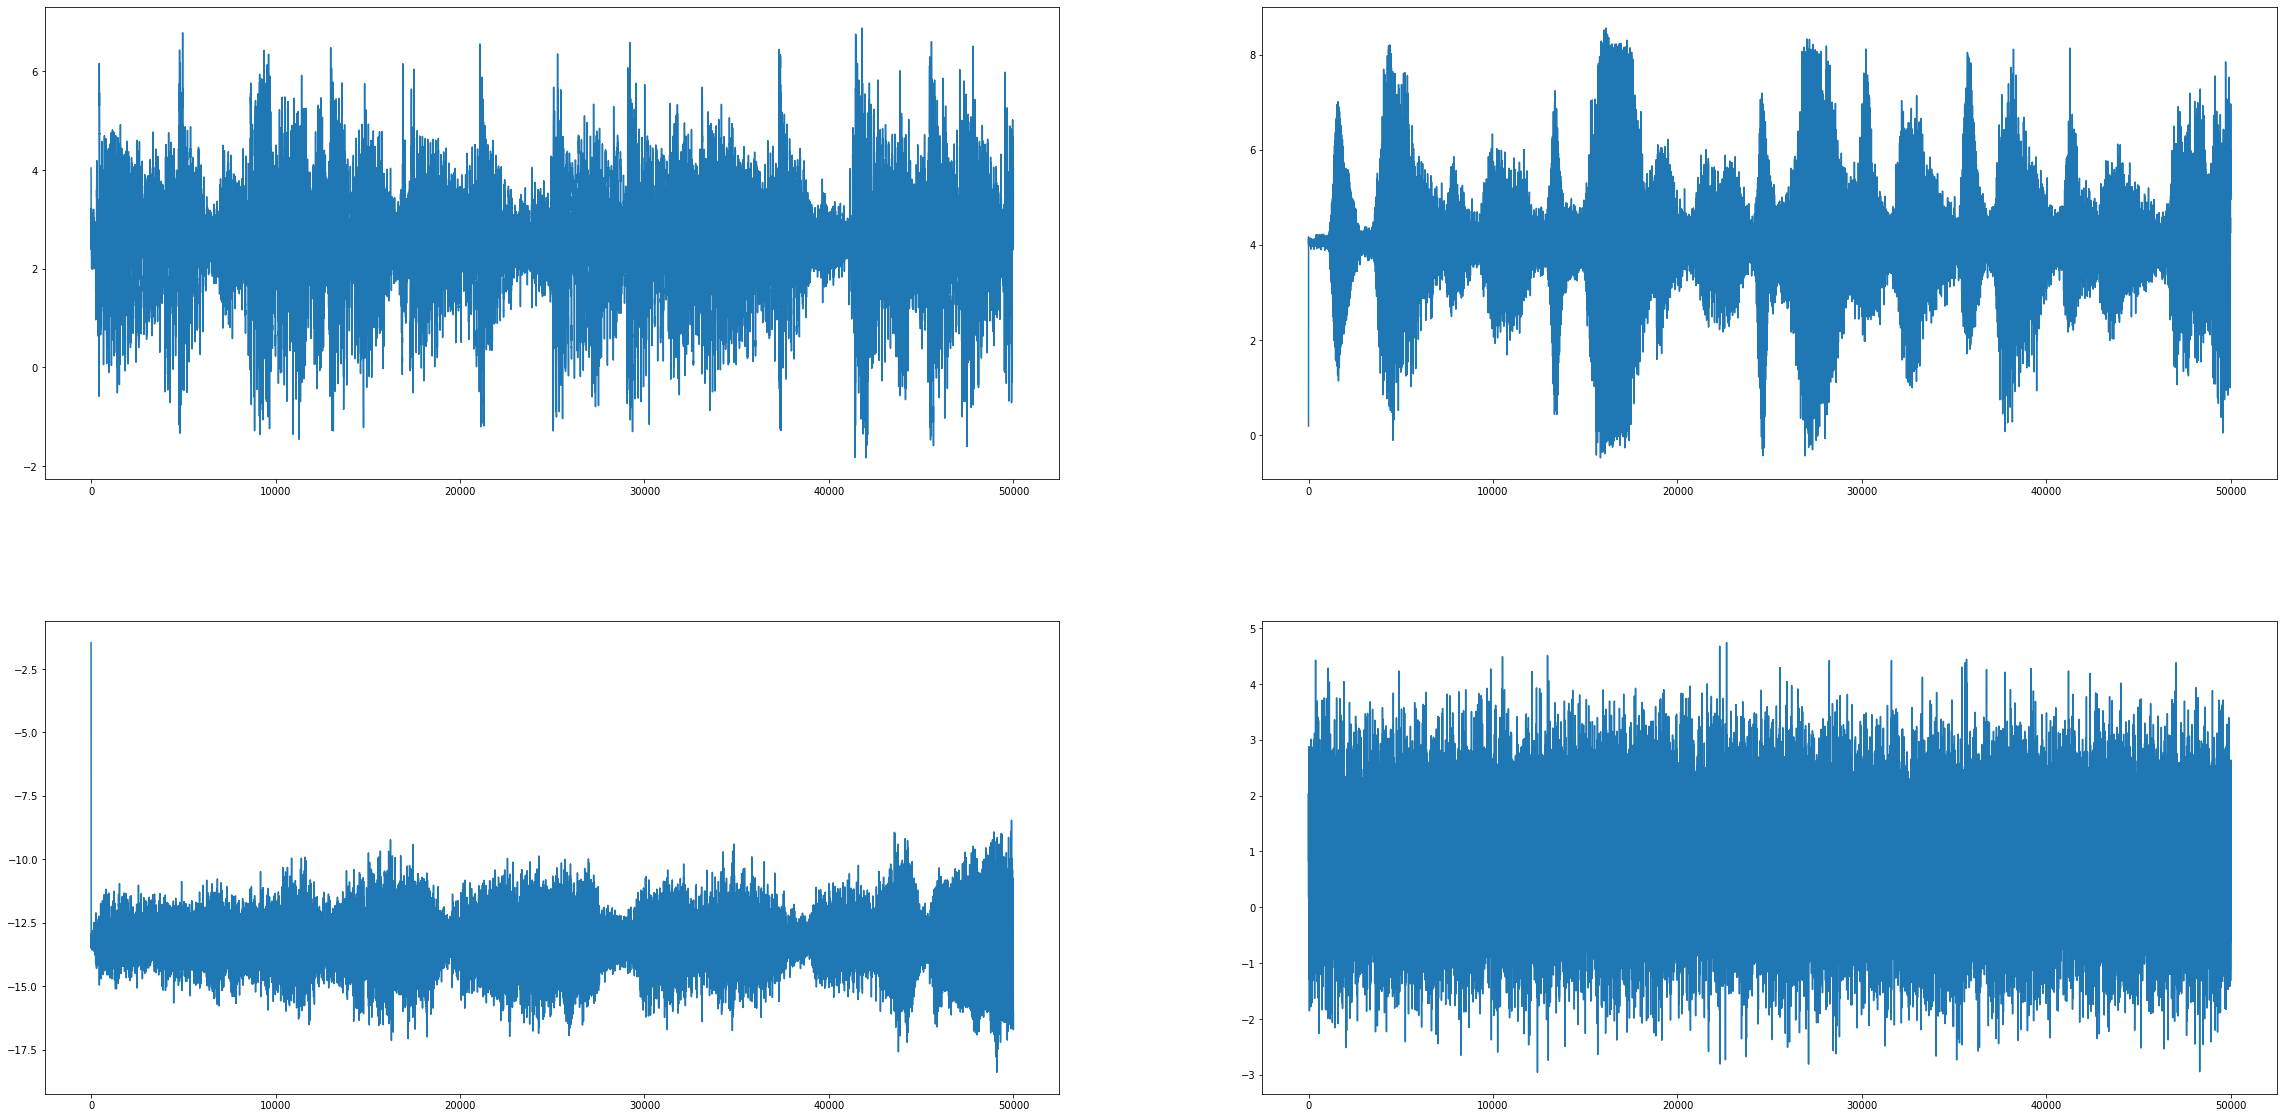

In [68]:
fig = plt.figure(figsize=(40,20),facecolor=(1, 1, 1))
X_new = np.array(B_rand @ X, np.float64)
axs = fig.subplots(h,w)
plt.subplots_adjust(hspace=0.3)
for i in range(X_new.shape[0]):
    ax = axs[i // w, i % w]
    ax.plot(X_new[i])
plt.savefig("Unmixed Signal RJD.png",bbox_inches='tight')

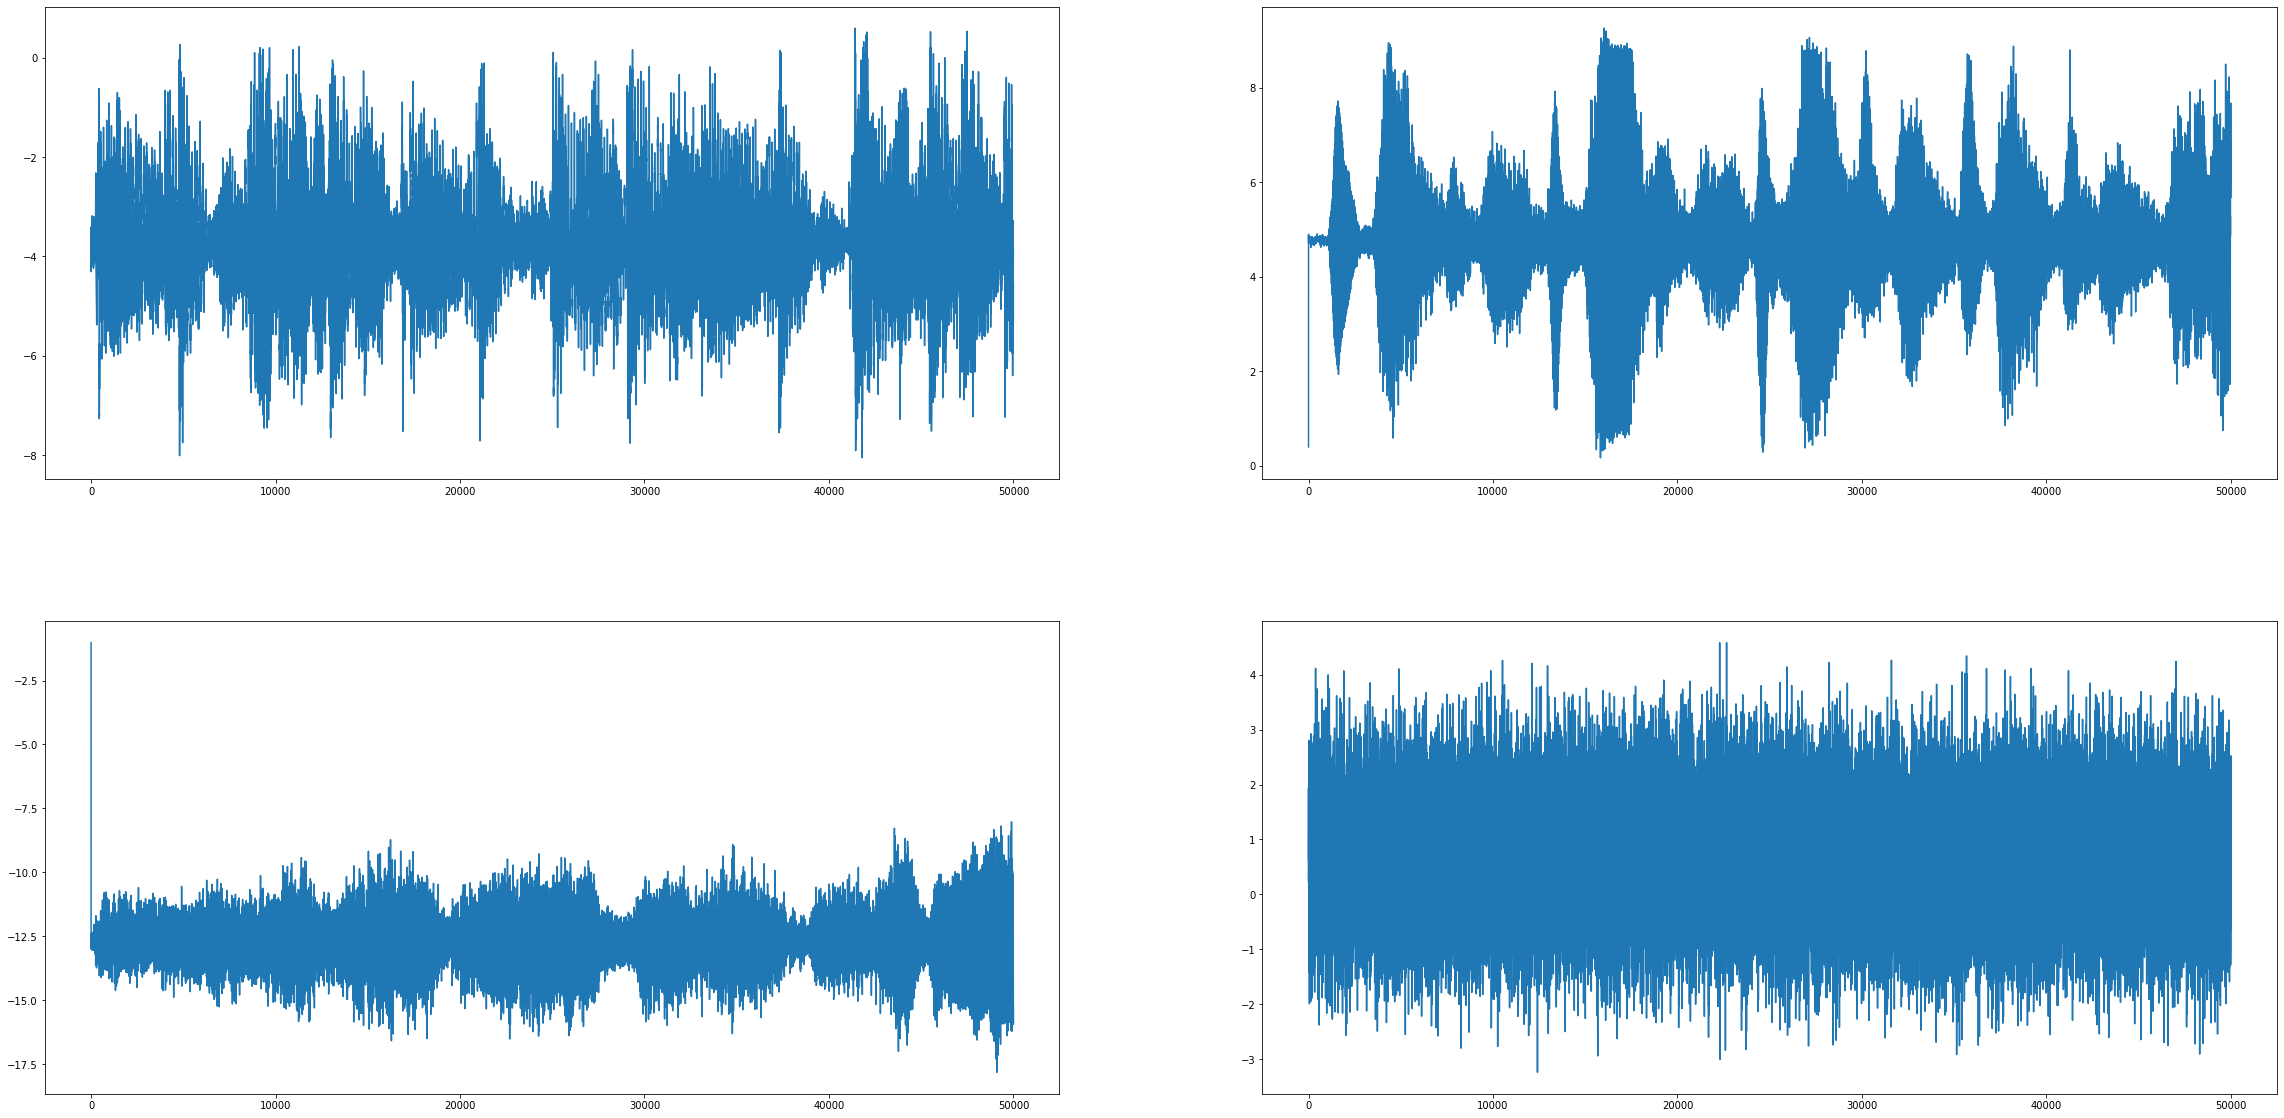

In [69]:
fig = plt.figure(figsize=(40,20),facecolor=(1, 1, 1))
X_new = np.array(B_rand_deflat @ X, np.float64)
axs = fig.subplots(h,w)
plt.subplots_adjust(hspace=0.3)
#fig.suptitle('Unmixed Signals', fontsize=22)
for i in range(X_new.shape[0]):
    #print(i// w, i % w)
    ax = axs[i // w, i % w]
    #ax.set(title="Unmixed Signal %d" % i)
    #ax.figure()
    ax.plot(X_new[i])
    #ax.title('Mixed Signal %d' % (i+1))
plt.savefig("Unmixed Signal DRJD.png",bbox_inches='tight')

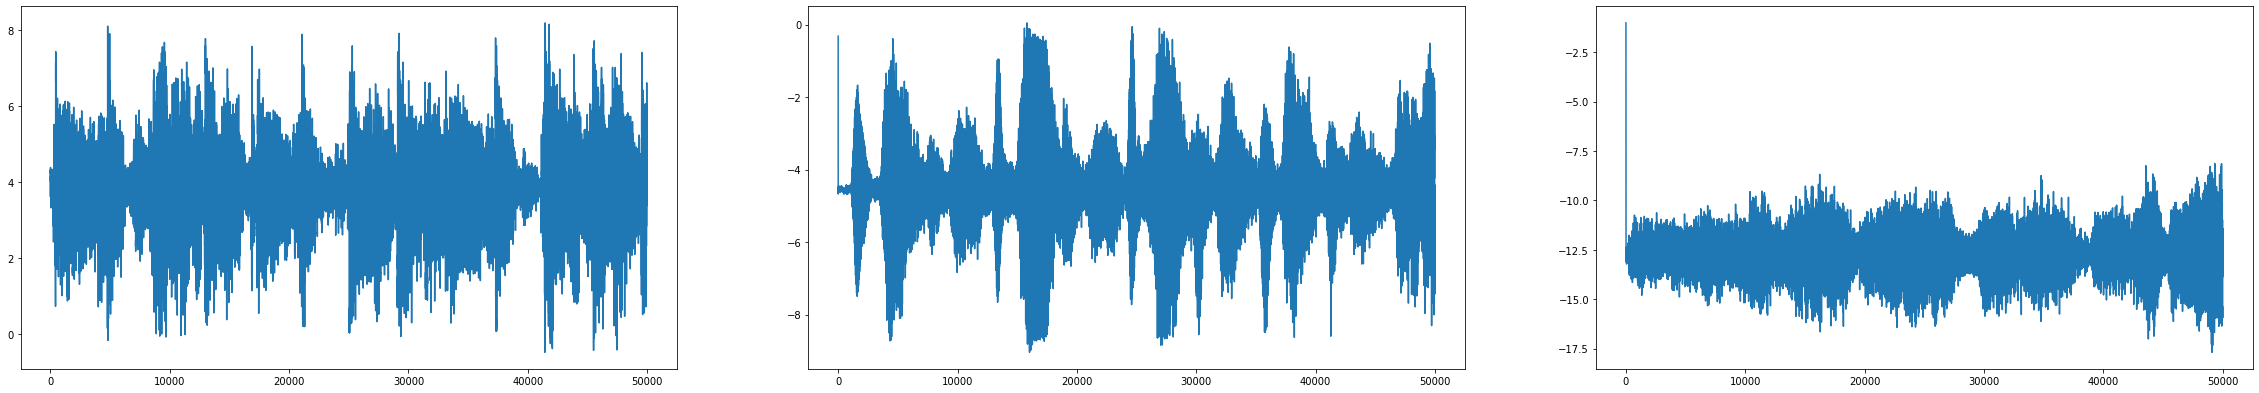

In [21]:
fig = plt.figure(figsize=(40,6.666),facecolor=(1, 1, 1))
X_new = np.array(B_rand_deflat @ X, np.float64)
axs = fig.subplots(1,3)
plt.subplots_adjust(hspace=0.3)
for i in range(X_new[:3].shape[0]):
    ax = axs[i ]
    ax.plot(X_new[i])
plt.savefig("Unmixed Signal DRJD poster.png",bbox_inches='tight')

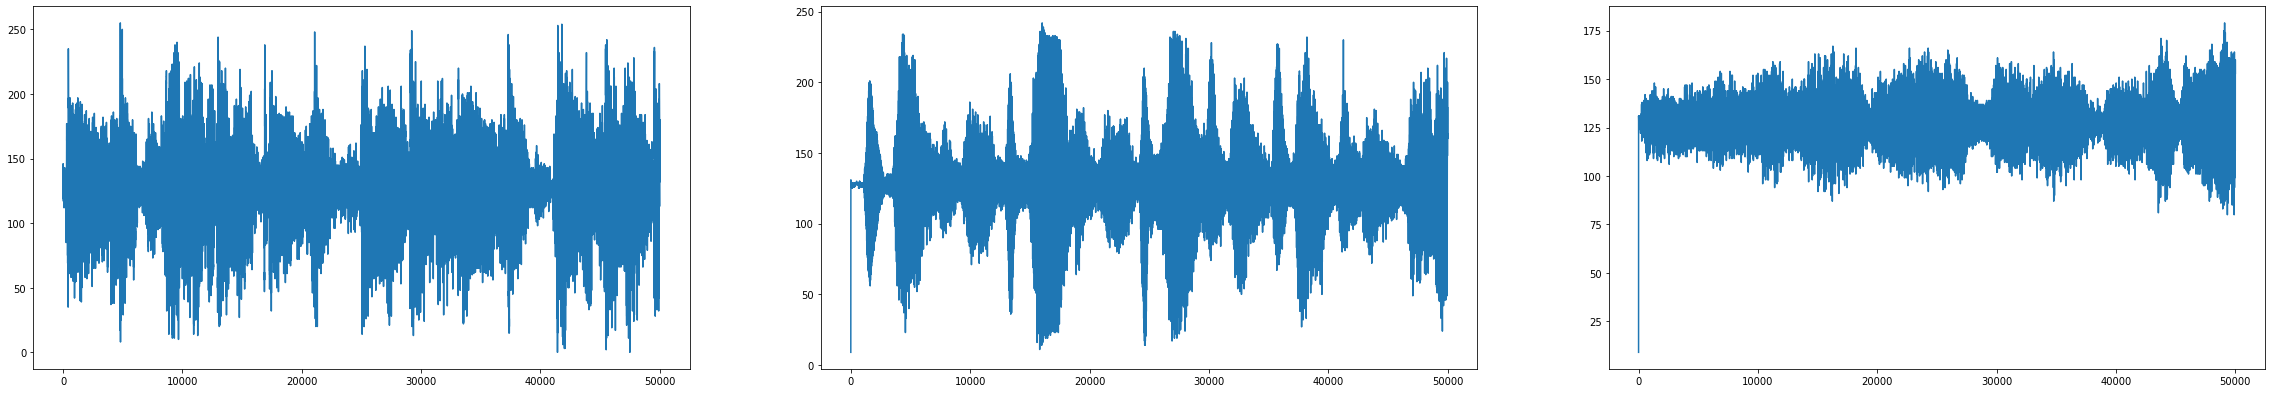

In [22]:
fig = plt.figure(figsize=(40,6.666),facecolor=(1, 1, 1))
axs = fig.subplots(1,3)
plt.subplots_adjust(hspace=0.3)
for i in range(S[:3].shape[0]):
    ax = axs[i]
    ax.plot(S[i])
plt.savefig("Original Signal poster.png",bbox_inches='tight')